In [2]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from PIL import Image
from collections import Counter
import random
import seaborn as sns
import wandb

In [4]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("garythung/trashnet")

# Inspect the structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})


In [19]:
import os
# Specify a local directory to store the dataset
save_dir = './trashnet_data'
os.makedirs(save_dir, exist_ok=True)
    
# Create a folder for each label inside the local directory
label_names = dataset['train'].features['label'].names
for label_name in label_names:
    os.makedirs(os.path.join(save_dir, label_name), exist_ok=True)
# Save each image into a folder according to its label

for i, example in enumerate(dataset['train']):
    image = example['image']
    label = label_names[example['label']]
    
# Specify the path to save the image.
    image_path = os.path.join(save_dir, label, f"image_{i}.jpg")
    image.save(image_path)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path ke dataset lokal
data_dir = './trashnet_data'

# Parameter Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,            # Normalisasi nilai piksel ke [0, 1]
    rotation_range=20,            # Rotasi gambar secara acak hingga 20 derajat
    width_shift_range=0.2,        # Pergeseran horizontal secara acak (20% dari lebar gambar)
    height_shift_range=0.2,       # Pergeseran vertikal secara acak (20% dari tinggi gambar)
    shear_range=0.15,             # Transformasi shear
    zoom_range=0.2,               # Zoom secara acak
    horizontal_flip=True,         # Membalik gambar secara horizontal
    validation_split=0.2         # Split dataset menjadi train dan validation
)

# Generator untuk data training
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),       # Ukuran gambar yang dihasilkan
    batch_size=32,                # Ukuran batch
    class_mode='categorical',     # Kategori label (untuk classification)
    subset='training'             # Subset data training
)

# Generator untuk data validation
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'           # Subset data validation
)


Found 4046 images belonging to 6 classes.
Found 1008 images belonging to 6 classes.


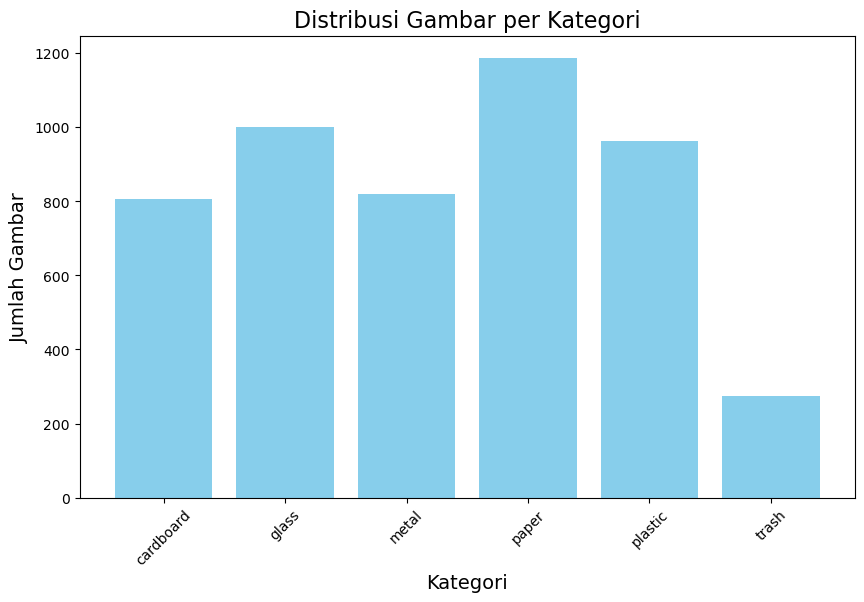

In [21]:
import matplotlib.pyplot as plt
from collections import Counter

# Hitung jumlah gambar di setiap kategori
category_counts = Counter([label_names[example['label']] for example in dataset['train']])

# Visualisasi distribusi kelas
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.title('Distribusi Gambar per Kategori', fontsize=16)
plt.xlabel('Kategori', fontsize=14)
plt.ylabel('Jumlah Gambar', fontsize=14)
plt.xticks(rotation=45)
plt.show()


In [22]:
label_counts = Counter(dataset['train']['label'])
print("Number of images per class:")
for label, count in label_counts.items():
    print(f"{label_names[label]}: {count} images")

Number of images per class:
cardboard: 806 images
glass: 1002 images
metal: 820 images
paper: 1188 images
plastic: 964 images
trash: 274 images


In [23]:
label_names = dataset['train'].features['label'].names

print("Label List:")
for idx, label_name in enumerate(label_names):
    print(f"{idx} = {label_name}")

Label List:
0 = cardboard
1 = glass
2 = metal
3 = paper
4 = plastic
5 = trash


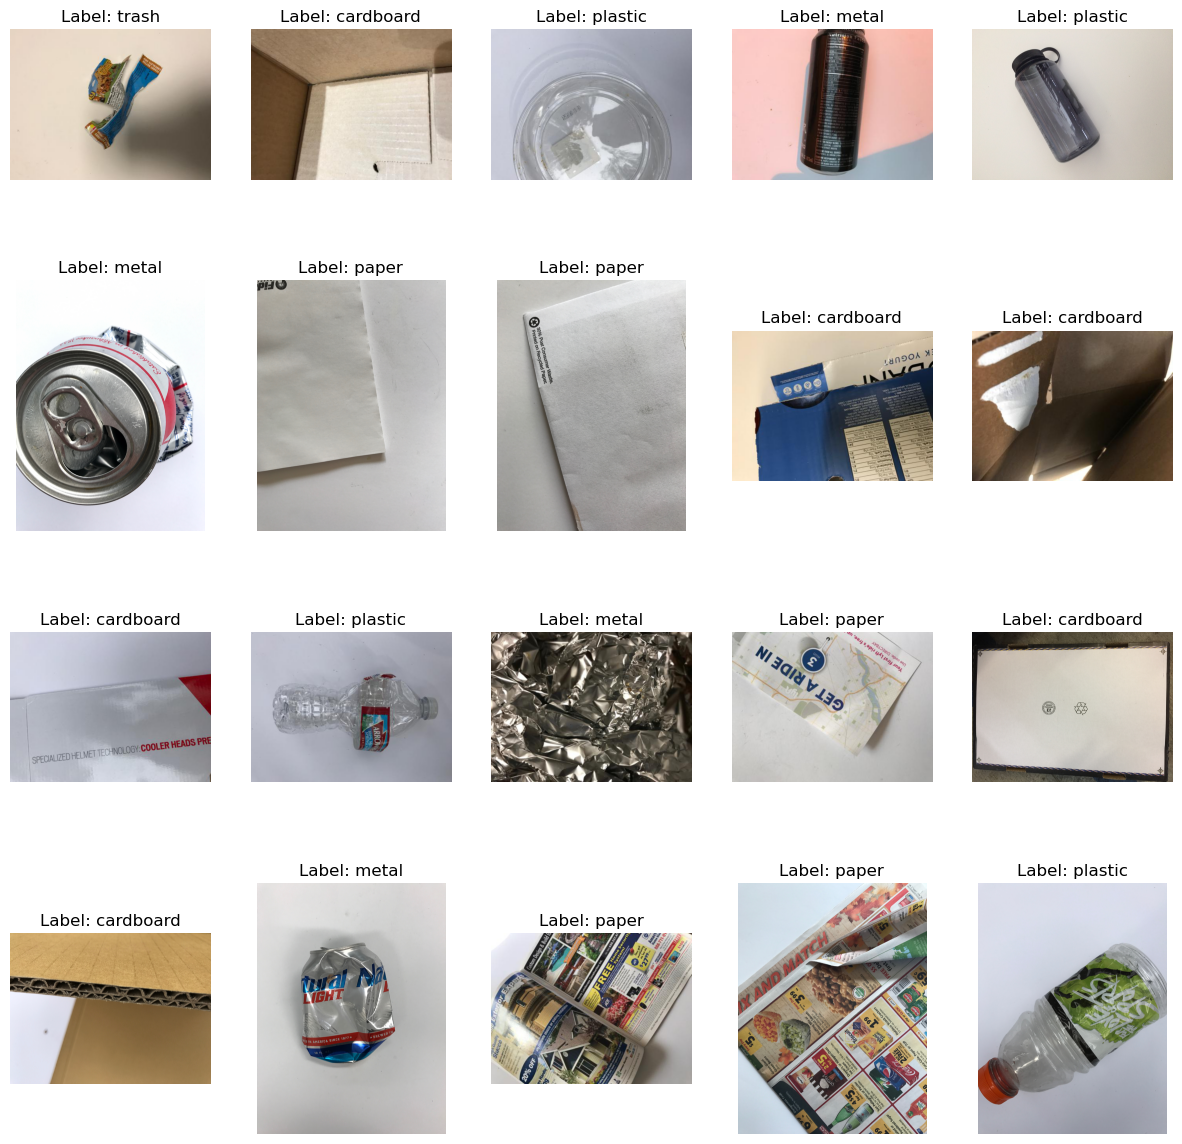

In [24]:
# Function to display 20 random samples from the dataset
def show_random_samples(dataset, num_samples=20):
    random_indices = random.sample(range(len(dataset['train'])), num_samples)

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        sample = dataset['train'][idx]
        image = sample['image']
        label = sample['label']

        plt.subplot(4, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {label_names[label]}")
        plt.axis("off")
    plt.show()

# Display 20 random samples
show_random_samples(dataset)


In [25]:
!wandb login 

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\surhe\_netrc


In [26]:
# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

C:\Users\surhe\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,044,550 (3.98 MB)

 Trainable params: 1,044,550 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
# Initialize wandb with configuration
epochs = 25
wandb.init(
    project="TrashClassifications",
    config={
        "epochs": epochs,
        "batch_size": train_generator.batch_size,
        "image_size": (150, 150),
        "model_architecture": "CNN"
    }
)

# Custom Callback for logging metrics to wandb
class WandbLoggingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Log training and validation metrics at the end of each epoch
        wandb.log({
            'epoch': epoch,
            'loss': logs['loss'],
            'accuracy': logs['accuracy'],
            'val_loss': logs['val_loss'],
            'val_accuracy': logs['val_accuracy']
        })

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: m1nees. Use `wandb login --relogin` to force relogin


In [30]:
# Training the model
epochs = 25
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[WandbLoggingCallback()]
)

C:\Users\surhe\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
127/127 ━━━━━━━━━━━━━━━━━━━━ 10:00 5s/step - accuracy: 0.3750 - loss: 1.75 ━━━━━━━━━━━━━━━━━━━━ 5:13 3s/step - accuracy: 0.3281 - loss: 1.8140 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.3194 - loss: 1.809 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.3060 - loss: 1.804 ━━━━━━━━━━━━━━━━━━━━ 4:52 2s/step - accuracy: 0.2948 - loss: 1.798 ━━━━━━━━━━━━━━━━━━━━ 4:46 2s/step - accuracy: 0.2865 - loss: 1.792 ━━━━━━━━━━━━━━━━━━━━ 4:50 2s/step - accuracy: 0.2832 - loss: 1.786 ━━━━━━━━━━━━━━━━━━━━ 4:56 2s/step - accuracy: 0.2805 - loss: 1.782 ━━━━━━━━━━━━━━━━━━━━ 5:04 3s/step - accuracy: 0.2779 - loss: 1.779 ━━━━━━━━━━━━━━━━━━━━ 4:59 3s/step - accuracy: 0.2748 - loss: 1.777 ━━━━━━━━━━━━━━━━━━━━ 4:56 3s/step - accuracy: 0.2723 - loss: 1.775 ━━━━━━━━━━━━━━━━━━━━ 4:57 3s/step - accuracy: 0.2700 - loss: 1.773 ━━━━━━━━━━━━━━━━━━━━ 5:02 3s/step - accuracy: 0.2675 - loss: 1.771 ━━━━━━━━━━━━━━━━━━━━ 5:03 3s/step - accuracy: 0.2648 - loss: 1.769 ━━━━━━━━━━━━━━━━━━━━ 5:05 3s/step - accura

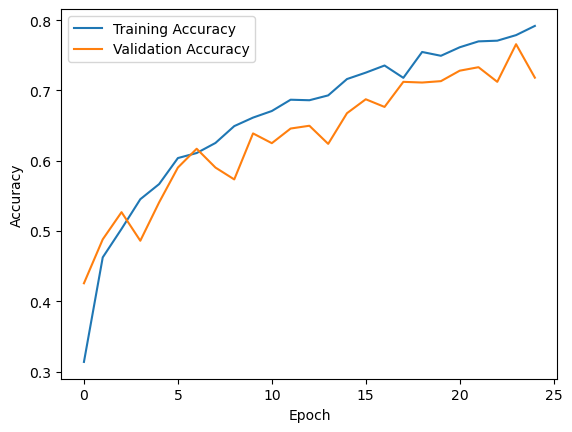

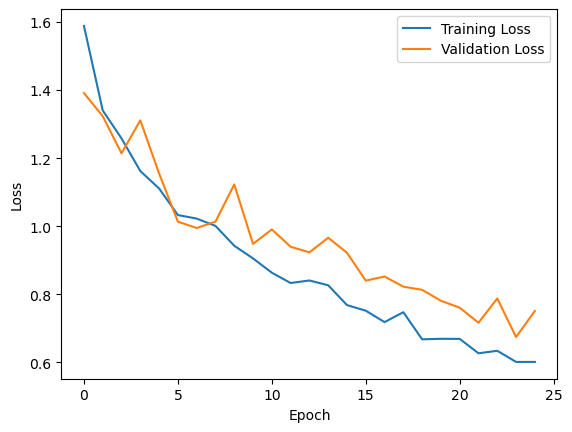

In [33]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [34]:
# Evaluating the model on the validation data
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1:57 4s/step - accuracy: 0.5938 - loss: 1.078 ━━━━━━━━━━━━━━━━━━━━ 1:38 3s/step - accuracy: 0.6562 - loss: 0.926 ━━━━━━━━━━━━━━━━━━━━ 1:34 3s/step - accuracy: 0.6736 - loss: 0.868 ━━━━━━━━━━━━━━━━━━━━ 1:31 3s/step - accuracy: 0.6751 - loss: 0.842 ━━━━━━━━━━━━━━━━━━━━ 1:27 3s/step - accuracy: 0.6776 - loss: 0.832 ━━━━━━━━━━━━━━━━━━━━ 1:25 3s/step - accuracy: 0.6801 - loss: 0.823 ━━━━━━━━━━━━━━━━━━━━ 1:22 3s/step - accuracy: 0.6825 - loss: 0.820 ━━━━━━━━━━━━━━━━━━━━ 1:18 3s/step - accuracy: 0.6836 - loss: 0.820 ━━━━━━━━━━━━━━━━━━━━ 1:14 3s/step - accuracy: 0.6856 - loss: 0.820 ━━━━━━━━━━━━━━━━━━━━ 1:10 3s/step - accuracy: 0.6882 - loss: 0.818 ━━━━━━━━━━━━━━━━━━━━ 1:08 3s/step - accuracy: 0.6918 - loss: 0.814 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - accuracy: 0.6949 - loss: 0.810 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - accuracy: 0.6975 - loss: 0.807 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.7003 - loss: 0.803 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.7030 - los

In [35]:
# Saving the trained model
model.save('trash_classification_model.h5')